
<a href="https://colab.research.google.com/github/thivinanandh/Teaching-Python/blob/main/Python-Libraries/Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Solving 2D Navier Stokes using Physics-Informed Neural Networks (PINNs)**

**Introduction**

In this tutorial, we will solve a demonstrative case of Navier-Stokes equation (Falkner–Skan Boundary Layer [Wikipedia](https://en.wikipedia.org/wiki/Falkner%E2%80%93Skan_boundary_layer)) ($u, v = 0$ on the boundary). In two dimensions, the governing equations take the form:

Continuity Equation (Conservation of Mass)
$$\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} = 0$$
Momentum Equation (x-direction)
$$u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = -\frac{\partial p}{\partial x} + \frac{1}{\text{Re}} \left(\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}\right)$$
Momentum Equation (y-direction)
$$u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = -\frac{\partial p}{\partial y} + \frac{1}{\text{Re}} \left(\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2}\right)$$
Where:

$u, v$ are velocity components in $x$ and $y$ directions
$p$ is pressure
$\text{Re}$ is the Reynolds number

Falkner–Skan Boundary Layers operates in the Low Reynolds number regime ($Re=100$)

Dimensionless Parameters

Reynolds number: $\text{Re} = \frac{UL}{\nu}$
$U$: Characteristic velocity
$L$: Characteristic length
$\nu$: Kinematic viscosity

## 1. Import Dependencies
___

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models, layers, optimizers, initializers
from time import time

## 2. Generate boundary and test data

We'll generate two sets of points to train our PINN:


1.   **Boundary Points:** These points lie on the edges of our domain


*   Uniformly spaced points.
*   Used to enforce Boundary conditions.


2.   **Interior Points:** These points lie inside our domain


*   Generated using random uniform sampling.
*   Used to enforce PDEs.

In [2]:
#################
# Training Parameters
#################

# Network and Training Parameters
activation = "tanh"
network_size = [20, 20, 20, 20, 20, 20, 20, 20]
epochs = 2500
cp_step = 10
bc_step = 10
learning_rate = 1e-3

In [4]:
data = np.load("FalknerSkan_n0.08.npz")
x, y, U, V, P= data['x'].T, data['y'].T, data['u'].T, data['v'].T, data['p'].T

# Normalize data
x, y = x - x.min(), y - y.min()
ref = np.stack((U, V, P))

# Collection points
collocation_points = np.hstack([x[:, ::cp_step].reshape((-1, 1)), y[:, ::cp_step].reshape((-1, 1))])

# Boundary points
ind_bc = np.zeros(x.shape, dtype=bool)
ind_bc[[0, -1], ::bc_step] = True  # Top and bottom boundaries
ind_bc[:, [0, -1]] = True  # Left and right boundaries

x_bc, y_bc = x[ind_bc].flatten(), y[ind_bc].flatten()
U_bc, V_bc = U[ind_bc].flatten(), V[ind_bc].flatten()

# Boundary conditions
boundary_conditions = np.vstack([x_bc, y_bc, U_bc, V_bc]).T

# Randomly select a portion of the boundary points
np.random.seed(42)  # Ensure reproducibility
pp = 0.5  # Select 50% of boundary points randomly
boundary_conditions = boundary_conditions[np.random.rand(len(boundary_conditions)) < pp]
num_collocation_points, num_boundary_conditions = len(collocation_points), len(boundary_conditions)

## 3. Physics-Informed Neural Network (PINN)

In [7]:
class PINNModel(models.Model):
    def __init__(self, neural_network, optimizer, epochs, nu, **kwargs):
        """
        A Physics-Informed Neural Network (PINN) model for solving partial differential equations.

        This model combines neural network predictions with physical constraints
        (residual losses) to solve complex scientific problems.

        Attributes:
            neural_network (tf.keras.Model): The underlying neural network architecture
            optimizer (tf.keras.optimizers.Optimizer): Optimization algorithm for training
            epochs (int): Number of training epochs
            nu (float): Viscosity or diffusion coefficient
            history (list): Stores training loss history
            residual_history (dict): Tracks individual residual losses
            current_epoch (int): Current training epoch
            xmax, xmin (tf.Tensor): Maximum and minimum scaling values for inputs
            ymax (tf.Tensor): Maximum scaling value for outputs
        """
        super(PINNModel, self).__init__(**kwargs)
        self.neural_network = neural_network
        self.optimizer = optimizer
        self.epochs = epochs
        self.history = []
        self.residual_history = {"r1": [], "r2": [], "r3": []}
        self.current_epoch = 0
        self.nu = nu

    @tf.function
    def train_step(self, boundary_conditions, collocation_points, epoch_log=100):
        """
        Perform a single training step for the Physics-Informed Neural Network.

        Computes predictions, calculates physics-based residuals, and computes gradients.

        Args:
            boundary_conditions (tf.Tensor): Tensor containing boundary condition data
            collocation_points (tf.Tensor): Tensor of collocation points for physics constraints
            epoch_log (int, optional): Frequency of logging. Defaults to 100.

        Returns:
            tuple: Containing total loss, gradients, loss history, and individual residual losses
        """
        X, y_bc = boundary_conditions[:, :2], boundary_conditions[:, 2:]

        with tf.GradientTape(persistent=True) as tape:
            predictions_bc = self.neural_network(X)[:, :-1]

            collocation_points = self.scale_x_r(collocation_points)

            x, y = collocation_points[:, 0], collocation_points[:, 1]

            tape.watch([x, y])

            X_scaled = self.scale_x(tf.stack([x, y], axis=-1))

            predictions = self.scale_y_r(self.neural_network(X_scaled))

            U, V, P = predictions[:, 0], predictions[:, 1], predictions[:, 2]

            U_x, U_y = tape.gradient(U, [x, y])
            V_x, V_y = tape.gradient(V, [x, y])

            # Second Order Derivatives

            U_xx, U_yy = tape.gradient(U_x, x), tape.gradient(U_y, y)
            V_xx, V_yy = tape.gradient(V_x, x), tape.gradient(V_y, y)
            P_x, P_y = tape.gradient(P, [x, y])

            res1 = U * U_x + V * U_y + P_x - self.nu * (U_xx + U_yy)
            res2 = U * V_x + V * V_y + P_y - self.nu * (V_xx + V_yy)
            res3 = U_x + V_y

            loss_bc = tf.reduce_mean(tf.square(y_bc - predictions_bc))

            loss_res1 = tf.reduce_mean(tf.square(res1))
            loss_res2 = tf.reduce_mean(tf.square(res2))
            loss_res3 = tf.reduce_mean(tf.square(res3))

            loss_r = loss_res1 + loss_res2 + loss_res3

            total_loss = loss_bc + loss_r


        gradients = tape.gradient(total_loss, self.trainable_variables)

        # tf.print('Total Loss:', total_loss, 'Boundary Condition Loss:', loss_bc, 'Residual Loss:', loss_r)
        return total_loss, gradients, tf.stack([total_loss, loss_bc, loss_r]), loss_res1, loss_res2, loss_res3

    def fit_scale_y(self, y):
        ymax = tf.reduce_max(tf.abs(y), axis = 0)
        self.ymax = tf.concat([ymax, [1.0]], 0)
        return y / ymax

    @tf.function
    def scale_y(self, y):
        return y / self.ymax

    @tf.function
    def scale_y_r(self, ys):
        return ys * self.ymax

    def fit_scale_x(self, x):
        xmax, xmin = tf.reduce_max(tf.abs(x), axis=0), tf.reduce_min(x, axis=0)
        self.xmax, self.xmin = xmax, xmin
        return (x - xmin ) / (xmax - xmin)

    @tf.function
    def scale_x(self, x):
        return (x - self.xmin) / (self.xmax - self.xmin)

    @tf.function
    def scale_x_r(self, xs):
        return xs * (self.xmax - self.xmin) + self.xmin

    def fit(self, boundary_conditions, collocation_points):
        boundary_conditions = tf.convert_to_tensor(boundary_conditions, tf.float32)
        collocation_points = tf.convert_to_tensor(collocation_points, tf.float32)

        x_bc, y_bc = boundary_conditions[:, :2], boundary_conditions[:, 2:]

        # Scale inputs
        y_bc = self.fit_scale_y(y_bc)
        x_bc = self.fit_scale_x(x_bc)
        collocation_points = self.scale_x(collocation_points)

        boundary_conditions_scaled = tf.concat([x_bc, y_bc], axis=1)

        # First Order Training Loop
        for epoch in range(self.epochs):
            # tf.print('Epoch:', self.current_epoch)
            loss, grads, hist, res1, res2, res3 = self.train_step(boundary_conditions_scaled, collocation_points)
            self.optimizer.apply_gradients(zip(grads, self.trainable_variables))
            self.current_epoch += 1
            self.history.append(hist.numpy())
            self.residual_history["r1"].append(res1.numpy())
            self.residual_history["r2"].append(res2.numpy())
            self.residual_history["r3"].append(res3.numpy())

        return np.array(self.history), {key: np.array(val) for key, val in self.residual_history.items()}

    def predict(self, collocation_points):
        collocation_points = self.scale_x(tf.convert_to_tensor(collocation_points, tf.float32))
        predictions = self.neural_network(collocation_points)
        return self.scale_y_r(predictions).numpy()


def rel_l2norm_err(ref, pred, var):
    """
    relative l2-norm of errors E_i on all computational points for i-th variable

    Args:
        ref: (nparray) Reference value of variables

        pred: (nparray) Prediction vallue computed by Neural Networks

    Return: (nparray) An array with shape of [N,I]
            N = number of points, I = number of variables

    """
    return np.linalg.norm(ref[:, var] - pred[:, var]) / np.linalg.norm(ref) * 100


## 4. Train Step


In [8]:
#################
# Model Compilation
#################

input_dimension = 2
output_dimension = 3

# Define Xavier initialization
initializer = initializers.GlorotUniform()


input_layer = layers.Input(shape=(input_dimension,), name='Input_Layer')
hidden_layer = input_layer


# Create Hidden layers
for idx, neurons in enumerate(network_size):
    layer_name = f'Hidden_Layer_{idx + 1}'
    hidden_layer = layers.Dense(neurons,
                                activation=activation,
                                name=layer_name,
                                kernel_initializer=initializer,
                                bias_initializer='zeros')(hidden_layer)

# The Output layer
output_layer = layers.Dense(output_dimension,
                            name='Output_Layer',
                            kernel_initializer=initializer,
                            bias_initializer='zeros')(hidden_layer)

# Create the model
model = models.Model(inputs=input_layer, outputs=output_layer)

model.summary()

# Optimizer with learning rate
optimizer = optimizers.Adam(learning_rate=learning_rate)

# Instantiate PINN model
nu = 0.01
PINN = PINNModel(model, optimizer, epochs, nu)

#################
# Training Process
#################
print(f"INFO: Starting training")
start_time = time()

# Train the model
history, residual_history = PINN.fit(boundary_conditions, collocation_points)

end_time = time()
comp_time = end_time - start_time

print("----------------------------------------")
print(f"Training completed in {comp_time:.2f} seconds")
print("----------------------------------------")

#################
# Prediction
#################

# Prepare test data for prediction
test_collocation_points = np.hstack([x.flatten().reshape((-1, 1)), y.flatten().reshape((-1, 1))])

# Make predictions
predicted_values = PINN.predict(test_collocation_points)
U_pred = predicted_values[:, 0].reshape(U.shape)
V_pred = predicted_values[:, 1].reshape(U.shape)
P_pred = predicted_values[:, 2].reshape(U.shape)

# Adjust predicted pressure by matching the reference pressure level
delta_p = P[0, 0] - P_pred[0, 0]
P_pred += delta_p

# Combine predictions
pred_combined = np.stack((U_pred, V_pred, P_pred))

#################
# Error Calculation (L2 norm error)
#################

l2_error_u = rel_l2norm_err(U, U_pred, 1)
l2_error_v = rel_l2norm_err(V, V_pred, 2)
l2_error_p = rel_l2norm_err(P, P_pred, 3)

print(f"\nL2 Errors - u: {l2_error_u}, v: {l2_error_v}, p: {l2_error_p}\n")

#################
# Save Prediction and Model
#################

# Save predictions and model
np.savez_compressed(f'res_FS', pred=pred_combined, ref=ref, x=x, y=y, res_hist= residual_history, hist=history, err=[l2_error_u, l2_error_v, l2_error_p], ct=comp_time)
model.save(f'model_FS.keras')

print("----------------------------------------")
print(f"Prediction and Model saved successfully")
print("----------------------------------------")



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)             │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_1 (Dense)               │ (None, 20)                  │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_2 (Dense)               │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_3 (Dense)               │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_4 (Dense)               │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_5 (Dense)               │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_6 (Dense)               │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_7 (Dense)               │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Hidden_Layer_8 (Dense)               │ (None, 20)                  │             420 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output_Layer (Dense)                 │ (None, 3)                   │              63 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,063 (11.96 KB)

 Trainable params: 3,063 (11.96 KB)

 Non-trainable params: 0 (0.00 B)

INFO: Starting training
----------------------------------------
Training completed in 997.78 seconds
----------------------------------------

L2 Errors - u: 0.012884736091132512, v: 0.015463761937470932, p: 0.0009750593993573017

----------------------------------------
Prediction and Model saved successfully
----------------------------------------


## 5. Postprocessing

Error U = 5.79807e-03 %
Error V = 5.69299e-03 %
Error P = 5.61515e-03 %


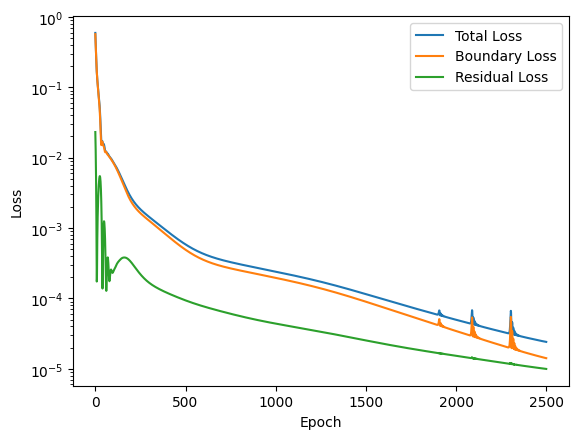

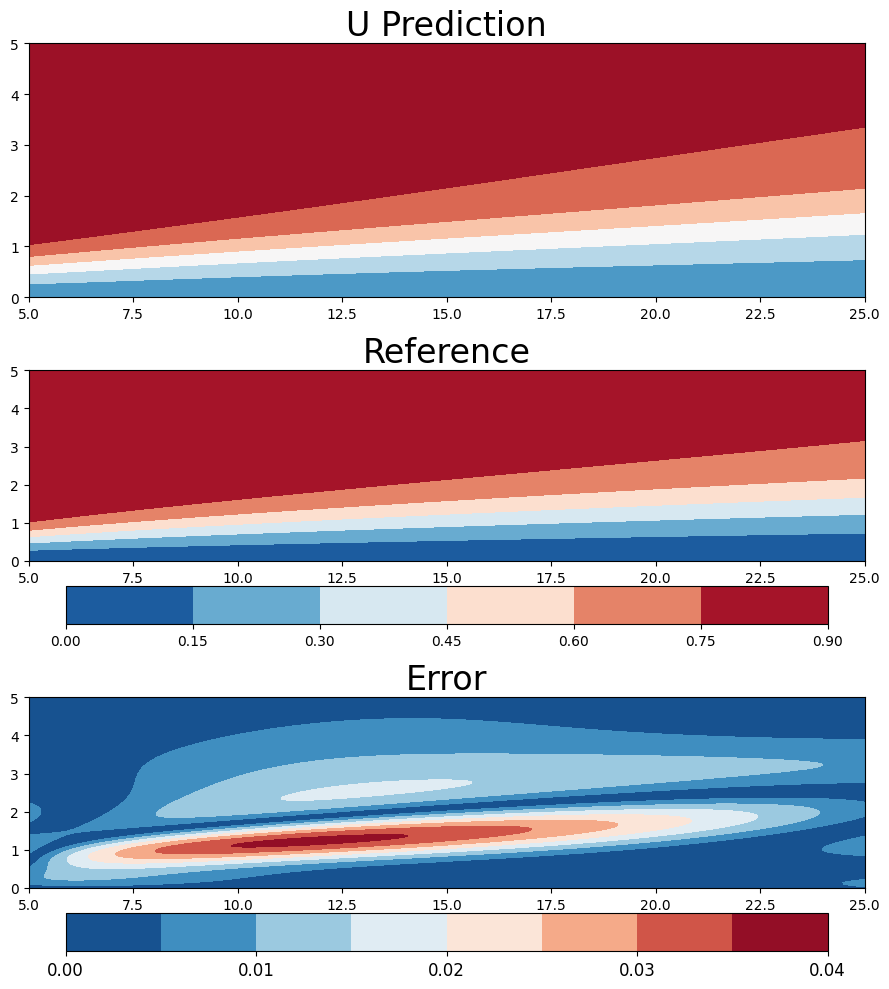

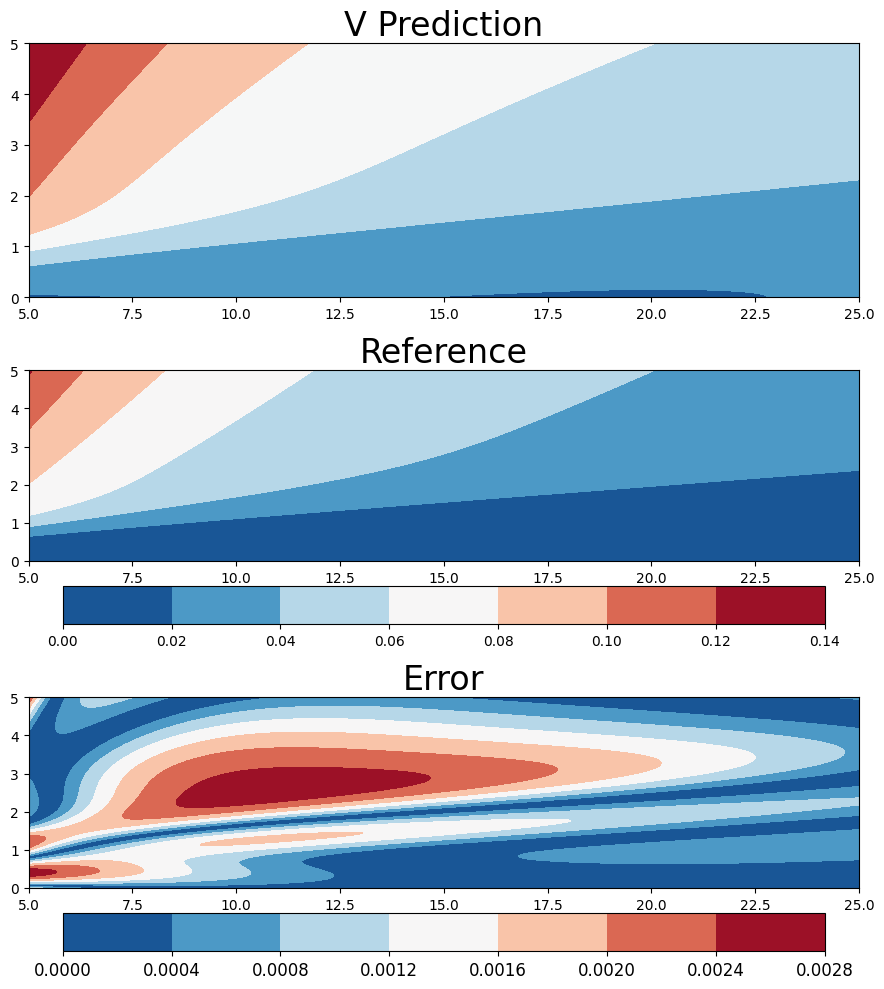

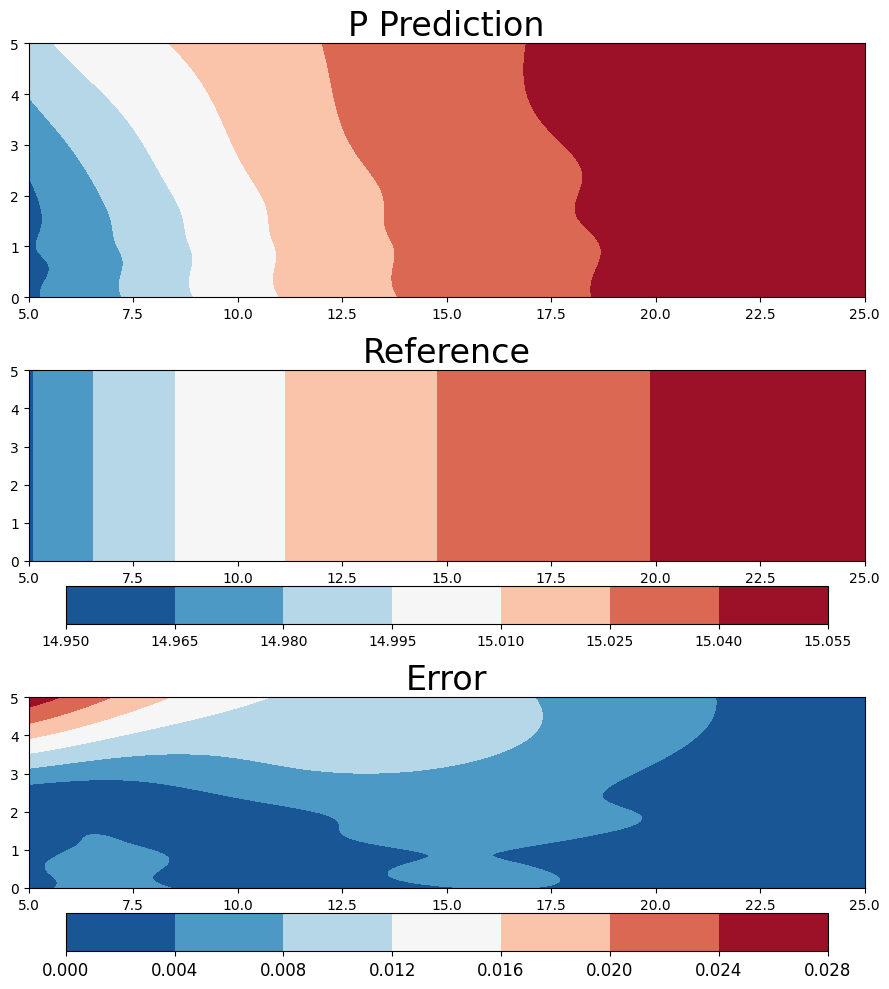

In [13]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

"""
Postprocessing of prediction data

Return:
    1. Loss vs Epoch
    2. U contour: Prediction, Reference, L1-norm
    3. V contour: Prediction, Reference, L1-norm
    4. P contour: Prediction, Reference, L1-norm
    5. Print l2-norm error
"""
cmap = sns.color_palette('RdBu_r', as_cmap=True)
plt.set_cmap(cmap)

data = np.load(f"res_FS.npz", allow_pickle=True)
d = np.load('FalknerSkan_n0.08.npz')
x = d['x'].T
y = d['y'].T

plt.semilogy(data['res_hist'].item()['r1'], label="X-momentum Loss")
plt.semilogy(data['res_hist'].item()['r2'], label="Y-momentum Loss")
plt.semilogy(data['res_hist'].item()['r3'], label="Continuity Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(f"Residual_Loss")
plt.cla()


epsilon = 1e-10
plt.semilogy(data['hist'][:, 0] + epsilon, label="Total Loss")
plt.semilogy(data['hist'][:, 1] + epsilon, label="Boundary Loss")
plt.semilogy(data['hist'][:, 2] + epsilon, label="Residual Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig(f"Total_Loss")

pred = data["pred"]
ref = data["ref"]
variables = ["U","V","P"]

for i, var in enumerate(variables):
    fig, ax = plt.subplots(3, figsize=(9, 10))
    ax[0].contourf(x, y, pred[i, :, :])
    clb_1 = ax[1].contourf(x, y, ref[i, :, :])
    plt.colorbar(clb_1, orientation="horizontal", pad=0.1)
    clb = ax[2].contourf(x, y, np.abs(ref[i, :, :] - pred[i, :, :]))
    cbar = plt.colorbar(clb, orientation="horizontal", pad=0.1)
    ax[0].set_title(f"{var} Prediction",fontdict={"size":24})
    ax[1].set_title("Reference",fontdict={"size":24})
    ax[2].set_title("Error",fontdict={"size":24})
    cbar.ax.locator_params(nbins=8)
    cbar.ax.tick_params(labelsize=12)
    plt.tight_layout()
    plt.savefig(f"{var}_contour",dpi= 300)


err = [rel_l2norm_err(ref, pred, var) for var in range(3)]
print(f"Error U = {err[0]:.5e} %\nError V = {err[1]:.5e} %\nError P = {err[2]:.5e} %")


## References:

1. Anandh, T., Ghose, D., Tyagi, A., Gupta, A., Sarkar, S., & Ganesan, S. (2024). An efficient hp-Variational PINNs framework for incompressible Navier-Stokes equations. arXiv preprint arXiv:2409.04143.

2. Eivazi, H., Tahani, M., Schlatter, P., & Vinuesa, R. (2022). Physics-informed neural networks for solving Reynolds-averaged Navier–Stokes equations. Physics of Fluids, 34(7).

Data and code is adapted from paper 2 for educational purposes.

